In [63]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [64]:
# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('Project_Data.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
979537,4,1833939503,Mon May 18 01:00:59 PDT 2009,NO_QUERY,NerdySabri,@ddlovato You're my favorite Your album makes...
521333,0,2192385510,Tue Jun 16 06:57:37 PDT 2009,NO_QUERY,leesamarie78,I'm moving my stuff out of my apt... I hate m...
460072,0,2072331647,Sun Jun 07 20:49:21 PDT 2009,NO_QUERY,kaelalovesyou,Hellos always end with goodbyes
1333199,4,2016382632,Wed Jun 03 06:40:50 PDT 2009,NO_QUERY,NeilCFord,Really must start attacking his pile of unread...
814745,4,1550908606,Sat Apr 18 07:36:18 PDT 2009,NO_QUERY,enzym,By @alipasha @oliverg man lernt ja nie aus #-h...


In [65]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [66]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [67]:
print('length of data is', len(df))


length of data is 1600000


In [68]:
df. shape

(1600000, 6)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [70]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

### Checking for Null values

In [71]:
np.sum(df.isnull().any(axis=1))

0

In [72]:
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   6
Count of rows in the data is:   1600000


### Check unique Target Values

In [73]:
df['target'].unique()

array([0, 4], dtype=int64)

### Check the number of target values

In [74]:
df['target'].nunique()

2

### Data Visualization of Target Variables

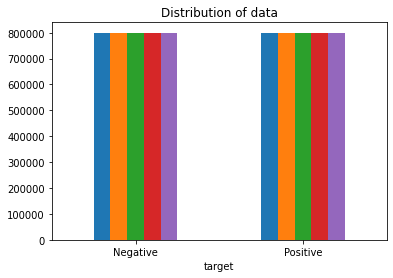

In [75]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

<AxesSubplot:xlabel='target', ylabel='count'>

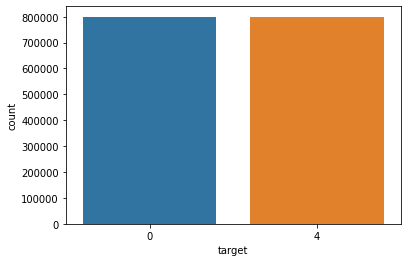

In [76]:
import seaborn as sns
sns.countplot(x='target', data=df)

### Selecting the text and Target column for our further analysis

In [77]:
data=df[['text','target']]

### Replacing the values to ease understanding. (Assigning 1 to Positive sentiment 4)

In [78]:
data['target'] = data['target'].replace(4,1)

C:\Users\alkis\AppData\Local\Temp/ipykernel_15492/2499609609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


### Print unique values of target variables

In [79]:
data['target'].unique()

array([0, 1], dtype=int64)

### Separating positive and negative tweets

In [80]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

### taking one fourth data so we can run on our machine easily

In [81]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

### Combining positive and negative tweets

In [82]:
dataset = pd.concat([data_pos, data_neg])

### Making statement text in lower case

In [83]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

### Defining set containing all stopwords in English.

In [84]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

### Cleaning and removing the above stop words list from the tweet text

In [85]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

### Cleaning and removing punctuations

In [86]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

### Cleaning and removing repeating characters

In [87]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

### Cleaning and removing URL’s

In [88]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

### Cleaning and removing Numeric numbers

In [89]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [98]:
dataset.iloc[19995:19996, :]

,text,target
819995,met awesome people tgi fridays,1


### Getting tokenization of tweet text

In [101]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

### Applying Stemming

In [102]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

### Applying Lemmatizer

In [103]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

### Separating input feature and label

In [104]:
X=data.text
y=data.target

### Plot a cloud of words for negative tweets

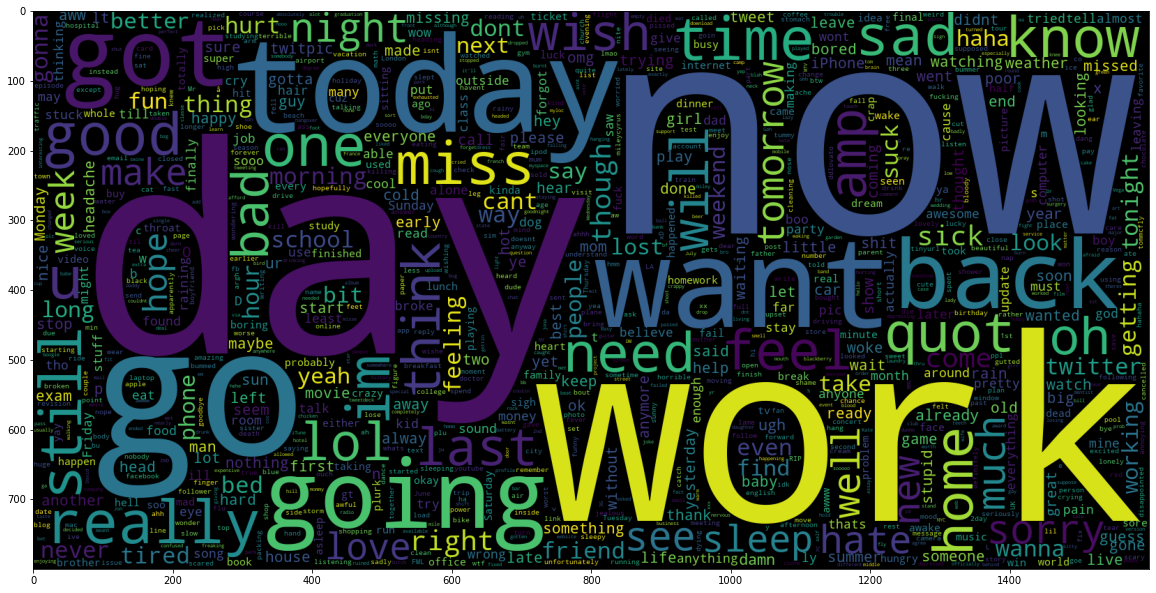

In [105]:
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

### Plot a cloud of words for positive tweets

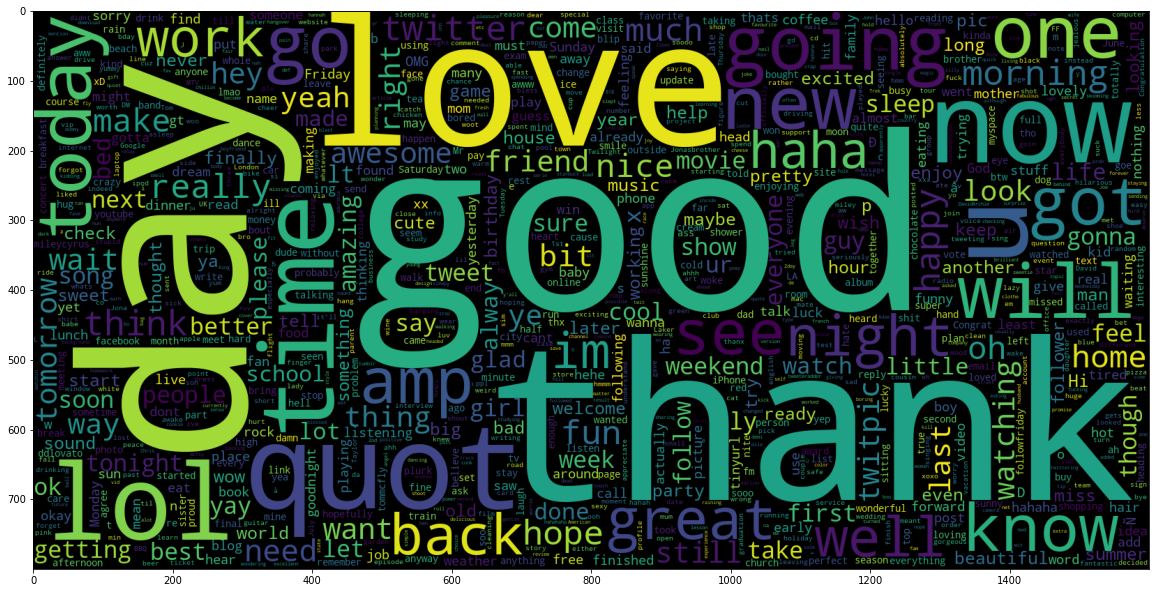

In [106]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

### Splitting our data into Train and Test Subset

In [107]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

### Transforming Dataset using TF-IDF Vectorizer

#### Fit the TF-IDF Vectorizer

In [108]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

C:\Users\alkis\anaconda3\envs\malakia\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000


#### Transform the data using TF-IDF Vectorizer

In [109]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

### Function For Model Evaluation

\begin{itemize}
\item Accuracy Score
\item Confusion Matrix with Plot
\item ROC-AUC Curve
\end{itemize}

In [112]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Model Building

In the problem statement we have used three different models respectively :
\begin{itemize}
\item Bernoulli Naive Bayes
\item SVM (Support Vector Machine)
\item Logistic Regression
\end{itemize}
The idea behind choosing these models is that we want to try all the classifiers on the dataset ranging from simple ones to complex models and then try to find out the one which gives the best performance among them.

 #### Model-1

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     40100
           1       0.80      0.81      0.80     39900

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



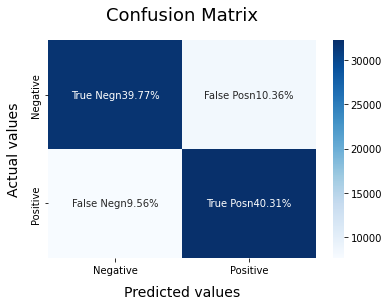

In [113]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

#### Plot the ROC-AUC Curve for model-1

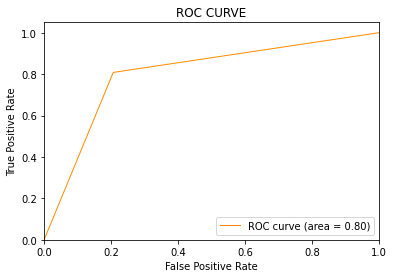

In [114]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

#### Model-2:

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     40100
           1       0.81      0.82      0.82     39900

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



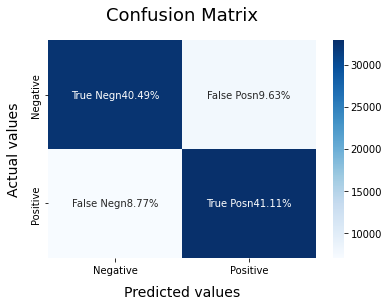

In [115]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

#### Plot the ROC-AUC Curve for model-2

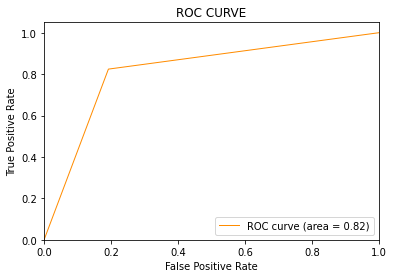

In [116]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

#### Model-3

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     40100
           1       0.82      0.84      0.83     39900

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



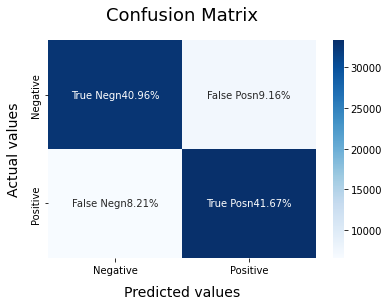

In [117]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

#### Plot the ROC-AUC Curve for model-3

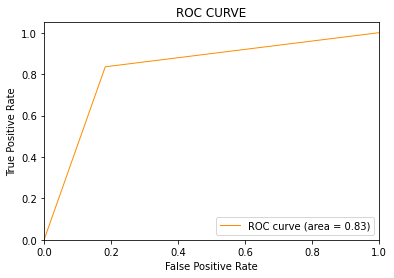

In [118]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### Conclusions

Upon evaluating all the models we can conclude the following details i.e.

Accuracy: As far as the accuracy of the model is concerned Logistic Regression performs better than SVM which in turn performs better than Bernoulli Naive Bayes.

F1-score: The F1 Scores for class 0 and class 1 are :
(a) For class 0: Bernoulli Naive Bayes(accuracy = 0.80) < SVM (accuracy =0.81) < Logistic Regression (accuracy = 0.83)
(b) For class 1: Bernoulli Naive Bayes (accuracy = 0.80) < SVM (accuracy = 0.82) < Logistic Regression (accuracy = 0.83)

AUC Score: The three models Bernoulli Naive Bayes, SVM and Logistic Regression have ROC-AUC score 0.80, 0.82, 0.83 respectively.

We, therefore, conclude that the Logistic Regression is the best model for the above-given dataset.

In our problem statement, Logistic Regression is following the principle of Occam’s Razor which defines that for a particular problem statement if the data has no assumption, then the simplest model works the best. Since our dataset does not have any assumptions and Logistic Regression is a simple model, therefore the concept holds true for the above-mentioned dataset.